Borehole Data:
    Borehole  X(m)  Y(m)  Upper Surface (m)   Lower Surface (m)
0          1    30    30              -18.5               -42.5
1          2   770    30              -17.5               -41.8
2          3  1230    30              -16.0               -41.3
3          4  1970    30              -14.6               -40.5
4          5    30   770              -32.2               -43.4
5          6   770   770              -20.8               -42.6
6          7  1230   770              -19.8               -42.1
7          8  1970   770              -18.3               -41.4
8          9    30  1230              -24.7               -44.0
9         10   770  1230              -23.2               -43.2
10        11  1230  1230              -22.2               -42.7
11        12  1970  1230              -20.8               -42.0
12        13    30  1970              -28.4               -44.8
13        14   770  1970              -27.0               -44.1
14        15  1230  1970 

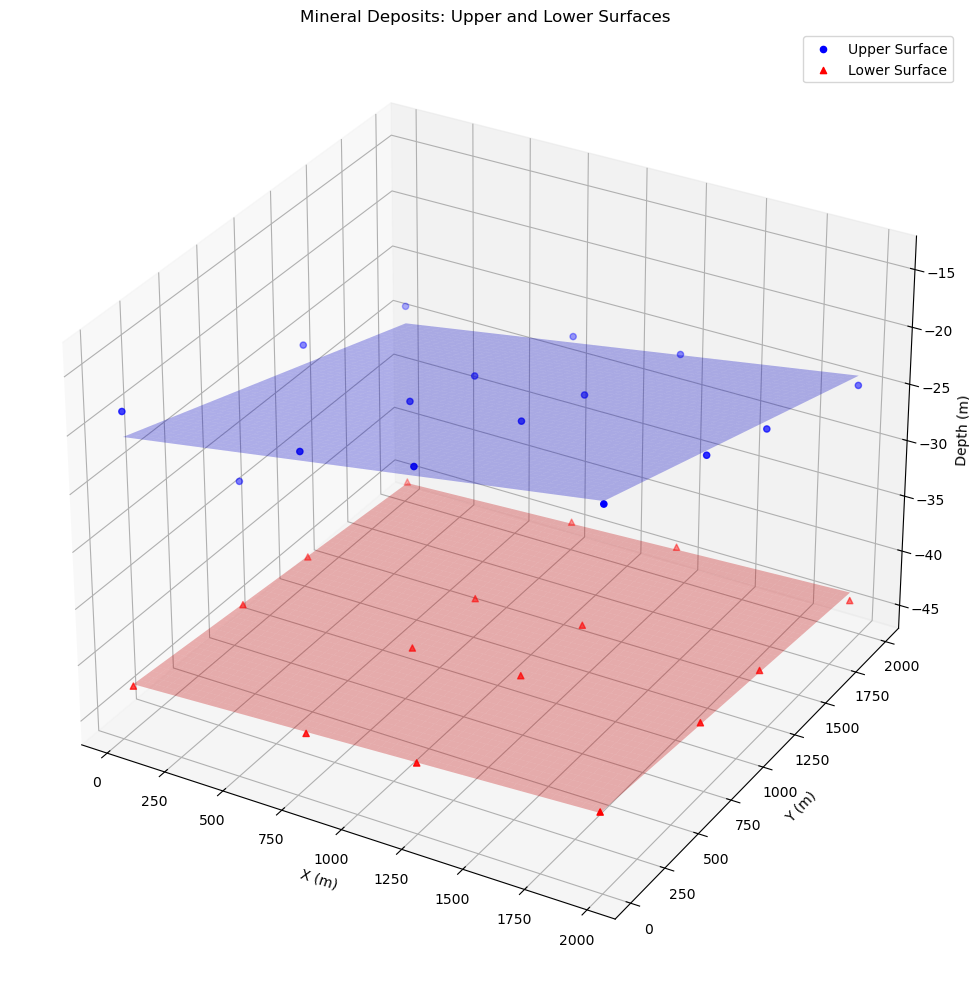

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Read the borehole data
borehole_data = pd.read_csv('borehole-data.csv')
print("Borehole Data:")
print(borehole_data)

# Print column names to debug
print("\nColumn names in the CSV file:")
for col in borehole_data.columns:
    print(f"'{col}'")

# Extract the data
# Find the columns by partial matching to handle potential whitespace issues
upper_col = [col for col in borehole_data.columns if 'Upper Surface' in col][0]
lower_col = [col for col in borehole_data.columns if 'Lower Surface' in col][0]

x = borehole_data['X(m)'].values
y = borehole_data['Y(m)'].values
upper_z = borehole_data[upper_col].values
lower_z = borehole_data[lower_col].values
N = len(x)

print(f"\nUsing columns: X(m), Y(m), {upper_col}, {lower_col}")

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the upper and lower surfaces
ax.scatter(x, y, upper_z, c='b', marker='o', label='Upper Surface')
ax.scatter(x, y, lower_z, c='r', marker='^', label='Lower Surface')

# Setting labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Depth (m)')
ax.set_title('Mineral Deposits: Upper and Lower Surfaces')
ax.legend()

# Set up matrix equations for upper surface: z(x, y) = a0 + a1*x + a2*y
# Matrix A is the same for both surfaces
A = np.zeros((3, 3))
A[0, 0] = N
A[0, 1] = np.sum(x)
A[0, 2] = np.sum(y)
A[1, 0] = np.sum(x)
A[1, 1] = np.sum(x**2)
A[1, 2] = np.sum(x * y)
A[2, 0] = np.sum(y)
A[2, 1] = np.sum(x * y)
A[2, 2] = np.sum(y**2)

# Right hand side for upper surface
b_upper = np.zeros(3)
b_upper[0] = np.sum(upper_z)
b_upper[1] = np.sum(x * upper_z)
b_upper[2] = np.sum(y * upper_z)

# Right hand side for lower surface
b_lower = np.zeros(3)
b_lower[0] = np.sum(lower_z)
b_lower[1] = np.sum(x * lower_z)
b_lower[2] = np.sum(y * lower_z)

# Solve for coefficients
coeffs_upper = np.linalg.solve(A, b_upper)
coeffs_lower = np.linalg.solve(A, b_lower)

print("\nUpper Surface Equation: z(x,y) = {:.4f} + {:.4f}*x + {:.4f}*y".format(
    coeffs_upper[0], coeffs_upper[1], coeffs_upper[2]))
print("Lower Surface Equation: z(x,y) = {:.4f} + {:.4f}*x + {:.4f}*y".format(
    coeffs_lower[0], coeffs_lower[1], coeffs_lower[2]))

# Create a grid for the plane surfaces
grid_x, grid_y = np.meshgrid(np.linspace(min(x), max(x), 50), 
                              np.linspace(min(y), max(y), 50))
grid_z_upper = coeffs_upper[0] + coeffs_upper[1] * grid_x + coeffs_upper[2] * grid_y
grid_z_lower = coeffs_lower[0] + coeffs_lower[1] * grid_x + coeffs_lower[2] * grid_y

# Plot the planes
ax.plot_surface(grid_x, grid_y, grid_z_upper, alpha=0.3, color='blue')
ax.plot_surface(grid_x, grid_y, grid_z_lower, alpha=0.3, color='red')

# Calculate average depth and volume
# Site dimensions are explicitly given as 2 km × 2 km
site_length = 2000  # 2 km = 2000 m
site_width = 2000   # 2 km = 2000 m
site_area = site_length * site_width  # 4,000,000 m²

# Sample the planes at a grid of points and calculate average thickness
num_samples = 100
sample_x = np.linspace(min(x), max(x), num_samples)
sample_y = np.linspace(min(y), max(y), num_samples)
xx, yy = np.meshgrid(sample_x, sample_y)
upper_surface = coeffs_upper[0] + coeffs_upper[1] * xx + coeffs_upper[2] * yy
lower_surface = coeffs_lower[0] + coeffs_lower[1] * xx + coeffs_lower[2] * yy

# Calculate thickness at each point
# For this problem:
# - Both surfaces have negative z-values (depths below surface)
# - Upper surface is closer to zero (less negative) than lower surface
# - So lower_z values are more negative than upper_z values
# - Thickness = |upper_z - lower_z|

# For raw data points
thickness_raw = np.abs(upper_z - lower_z)
avg_thickness_raw = np.mean(thickness_raw)

# For the fitted planes
# Both should be negative values, with lower surface more negative than upper
thickness_planes = np.abs(lower_surface - upper_surface)  # Should be positive values
avg_thickness_planes = np.mean(thickness_planes)

# Calculate volume (area × average thickness) - using the fitted planes value
volume = site_area * avg_thickness_planes

print(f"Average thickness from raw data points: {avg_thickness_raw:.2f} m")
print(f"Average thickness from fitted planes: {avg_thickness_planes:.2f} m")

# Print results
print("\nCalculations:")
print(f"Site dimensions: {site_length} m × {site_width} m")
print(f"Site area: {site_area} m²")
print(f"Average mineral deposit thickness: {avg_thickness_planes:.2f} m")
print(f"Total mineral deposit volume: {volume:.2f} m³")

# Display the plot
plt.tight_layout()
plt.show()


In [7]:
import numpy as np

# Define the function to be integrated
def f(x):
  return 3*x**2 + 4*x**3 + 5*x**4

# Define the exact solution (given)
exact_solution = 56

# Integration limits
a = 0
b = 2

# --- 1. Trapezoidal Rule ---
# Using 3 data ordinates means 2 intervals
n_trapezoid = 2 
x_trapezoid = np.linspace(a, b, n_trapezoid + 1)
y_trapezoid = f(x_trapezoid)
h_trapezoid = (b - a) / n_trapezoid

# Trapezoidal rule formula
trapezoidal_approximation = (h_trapezoid / 2) * (y_trapezoid[0] + 2*np.sum(y_trapezoid[1:-1]) + y_trapezoid[-1])

# --- 2. Simpson's Rule ---
# Using 3 data ordinates means 2 intervals
n_simpson = 2  
x_simpson = np.linspace(a, b, n_simpson + 1)
y_simpson = f(x_simpson)
h_simpson = (b - a) / n_simpson

# Simpson's rule formula
simpson_approximation = (h_simpson / 3) * (y_simpson[0] + 4*np.sum(y_simpson[1:-1:2]) + 2*np.sum(y_simpson[2:-2:2]) + y_simpson[-1])


# --- 3. Two-Point Gauss Quadrature ---

gauss_points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
gauss_weights = np.array([1, 1])

# Transformation from [-1, 1] to [a, b]
x_gauss = ((b - a) / 2) * gauss_points + ((a + b) / 2)
y_gauss = f(x_gauss)

# Gauss Quadrature formula
gauss_approximation = ((b - a) / 2) * np.sum(gauss_weights * y_gauss)

# --- Error Calculations ---

# Absolute Error = |Approximate Value - Exact Value|
abs_error_trapezoid = np.abs(trapezoidal_approximation - exact_solution)
abs_error_simpson = np.abs(simpson_approximation - exact_solution)
abs_error_gauss = np.abs(gauss_approximation - exact_solution)

# Relative Error = |Absolute Error / Exact Value|
rel_error_trapezoid = abs_error_trapezoid / np.abs(exact_solution)
rel_error_simpson = abs_error_simpson / np.abs(exact_solution)
rel_error_gauss = abs_error_gauss / np.abs(exact_solution)

# --- Output ---

print("Numerical Integration Results:\n")
print(f"Trapezoidal Rule Approximation: {trapezoidal_approximation}")
print(f"Simpson's Rule Approximation: {simpson_approximation}")
print(f"Gauss Quadrature Approximation: {gauss_approximation}\n")

print("Error Analysis:\n")
print(f"Trapezoidal Rule Absolute Error: {abs_error_trapezoid}")
print(f"Trapezoidal Rule Relative Error: {rel_error_trapezoid}")
print(f"Simpson's Rule Absolute Error: {abs_error_simpson}")
print(f"Simpson's Rule Relative Error: {rel_error_simpson}")
print(f"Gauss Quadrature Absolute Error: {abs_error_gauss}")
print(f"Gauss Quadrature Relative Error: {rel_error_gauss}")

Numerical Integration Results:

Trapezoidal Rule Approximation: 74.0
Simpson's Rule Approximation: 57.33333333333333
Gauss Quadrature Approximation: 55.11111111111111

Error Analysis:

Trapezoidal Rule Absolute Error: 18.0
Trapezoidal Rule Relative Error: 0.32142857142857145
Simpson's Rule Absolute Error: 1.3333333333333286
Simpson's Rule Relative Error: 0.023809523809523725
Gauss Quadrature Absolute Error: 0.8888888888888928
Gauss Quadrature Relative Error: 0.015873015873015945


In [5]:
import numpy as np
import pandas as pd

def f(x):
    """The function to integrate: 4/(1+x^2)"""
    return 4 / (1 + x**2)

def trapezoid(f, a, b, n):
    """
    Computes the trapezoid rule approximation with n subintervals
    """
    h = (b - a) / n
    x = np.linspace(a, b, n+1)
    y = [f(xi) for xi in x]
    
    # Trapezoid rule formula: h/2 * (f(a) + 2f(x₁) + 2f(x₂) + ... + 2f(xₙ₋₁) + f(b))
    return h/2 * (y[0] + 2*sum(y[1:-1]) + y[-1])

def romberg(f, a, b, max_level=4):
    """
    Performs Romberg integration
    Returns R matrix and errors
    """
    R = np.zeros((max_level+1, max_level+1))
    h = b - a
    
    # First column (R(i,0)) - trapezoid rule with h, h/2, h/4, ...
    for i in range(max_level+1):
        n = 2**i
        R[i, 0] = trapezoid(f, a, b, n)
    
    # Fill the Romberg table using the extrapolation formula
    for j in range(1, max_level+1):
        for i in range(j, max_level+1):
            # Romberg extrapolation formula
            R[i, j] = R[i, j-1] + (R[i, j-1] - R[i-1, j-1]) / (4**j - 1)
    
    # True value of the integral is π
    true_value = np.pi
    abs_errors = np.abs(R - true_value)
    rel_errors = abs_errors / true_value
    
    return R, abs_errors, rel_errors

def print_results(R, abs_errors, rel_errors, max_level):
    """Prints Romberg table and errors in nicely formatted tables"""
    print("Romberg Integration Table:")
    rows = []
    
    for i in range(max_level+1):
        row = [f"R({i},{j})" for j in range(i+1)]
        rows.append(row)
    
    df_labels = pd.DataFrame(rows)
    
    # Create table of values
    rows_values = []
    for i in range(max_level+1):
        row = [f"{R[i,j]:.10f}" for j in range(i+1)]
        rows_values.append(row)
    
    df_values = pd.DataFrame(rows_values)
    
    # Print label and value
    for i in range(max_level+1):
        line = ""
        for j in range(i+1):
            line += f"{df_labels.iloc[i,j]}: {df_values.iloc[i,j]}  "
        print(line)
        
    print("\nAbsolute Errors:")
    rows_abs_err = []
    for i in range(max_level+1):
        row = [f"{abs_errors[i,j]:.10f}" for j in range(i+1)]
        rows_abs_err.append(row)
    
    df_abs_err = pd.DataFrame(rows_abs_err)
    
    for i in range(max_level+1):
        line = ""
        for j in range(i+1):
            line += f"E({i},{j}): {df_abs_err.iloc[i,j]}  "
        print(line)
        
    print("\nRelative Errors (%):")
    rows_rel_err = []
    for i in range(max_level+1):
        row = [f"{rel_errors[i,j]*100:.8f}%" for j in range(i+1)]
        rows_rel_err.append(row)
    
    df_rel_err = pd.DataFrame(rows_rel_err)
    
    for i in range(max_level+1):
        line = ""
        for j in range(i+1):
            line += f"RE({i},{j}): {df_rel_err.iloc[i,j]}  "
        print(line)

# Main execution
max_level = 4  # Number of levels in Romberg table
a, b = 0, 1    # Integration limits
R, abs_errors, rel_errors = romberg(f, a, b, max_level)

print(f"True value = π = {np.pi:.10f}")
print_results(R, abs_errors, rel_errors, max_level)

# Specifically evaluate at the points mentioned in the problem
print("\nEvaluating f(x) at specified points:")
points = [0, 1/4, 1/2, 3/4, 1]
for x in points:
    print(f"f({x}) = {f(x):.10f}")

# To show how starting with those specific points works in Romberg integration:
print("\nRomberg integration starting with points [0, 1/4, 1/2, 3/4, 1]:")
# This means we start with n=4 intervals
h = 1/4
x_values = np.array([0, 1/4, 1/2, 3/4, 1])
y_values = f(x_values)

# Calculate initial trapezoid rule approximation with these points
R0 = h/2 * (y_values[0] + 2*sum(y_values[1:-1]) + y_values[-1])
print(f"Initial trapezoid approximation (h=1/4): {R0:.10f}")
print(f"Absolute error: {abs(R0 - np.pi):.10f}")
print(f"Relative error: {abs(R0 - np.pi)/np.pi*100:.8f}%")

True value = π = 3.1415926536
Romberg Integration Table:
R(0,0): 3.0000000000  
R(1,0): 3.1000000000  R(1,1): 3.1333333333  
R(2,0): 3.1311764706  R(2,1): 3.1415686275  R(2,2): 3.1421176471  
R(3,0): 3.1389884945  R(3,1): 3.1415925025  R(3,2): 3.1415940941  R(3,3): 3.1415857838  
R(4,0): 3.1409416120  R(4,1): 3.1415926512  R(4,2): 3.1415926611  R(4,3): 3.1415926384  R(4,4): 3.1415926653  

Absolute Errors:
E(0,0): 0.1415926536  
E(1,0): 0.0415926536  E(1,1): 0.0082593203  
E(2,0): 0.0104161830  E(2,1): 0.0000240261  E(2,2): 0.0005249935  
E(3,0): 0.0026041591  E(3,1): 0.0000001511  E(3,2): 0.0000014405  E(3,3): 0.0000068698  
E(4,0): 0.0006510415  E(4,1): 0.0000000024  E(4,2): 0.0000000076  E(4,3): 0.0000000152  E(4,4): 0.0000000117  

Relative Errors (%):
RE(0,0): 4.50703414%  
RE(1,0): 1.32393528%  RE(1,1): 0.26290233%  
RE(2,0): 0.33155740%  RE(2,1): 0.00076478%  RE(2,2): 0.01671106%  
RE(3,0): 0.08289296%  RE(3,1): 0.00000481%  RE(3,2): 0.00004585%  RE(3,3): 0.00021867%  
RE(4,0): 